In [2]:
# Import the dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import hvplot.pandas
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Read the CSV files
data1_2023 = pd.read_csv('Data/uber_nyc_2023_1.csv')
data2_2023 = pd.read_csv('Data/uber_nyc_2023_2.csv')
data3_2023 = pd.read_csv('Data/uber_nyc_2023_3.csv')

# Combine the DataFrames into one
df = pd.concat([data1_2023, data2_2023, data3_2023
               ], ignore_index=True)

# Display the first few rows of the combined DataFrame
df.head()

,Unnamed: 0,DOLocationID,PULocationID,hvfhs_license_num,request_datetime,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,date,PUBorough,PUZone,DOBorough,DOZone
0,0,145,223,HV0003,2023-01-01T00:50:41.000,3.83,1131,18.74,0.00,0.56,1.66,0.00,0.0,0.00,17.55,2023-01-01,Queens,Steinway,Queens,Long Island City/Hunters Point
1,1,151,236,HV0003,2023-01-01T00:48:34.000,1.84,645,16.64,0.00,0.50,1.48,2.75,0.0,3.09,13.75,2023-01-01,Manhattan,Upper East Side North,Manhattan,Manhattan Valley
2,2,78,60,HV0003,2023-01-01T00:27:48.000,1.75,633,24.23,0.00,0.73,2.15,0.00,0.0,0.00,13.92,2023-01-01,Bronx,Crotona Park East,Bronx,East Tremont
3,3,95,175,HV0003,2023-01-01T00:51:30.000,7.13,797,21.03,0.00,0.63,1.87,0.00,0.0,4.70,15.98,2023-01-01,Queens,Oakland Gardens,Queens,Forest Hills
4,4,182,198,HV0003,2023-01-01T00:28:43.000,14.07,1848,55.87,6.55,1.87,5.54,0.00,0.0,6.98,38.79,2023-01-01,Queens,Ridgewood,Bronx,Parkchester


In [15]:
# Printing the shape of the DataFrame (rows, columns)
print(df.shape)

(1670353, 20)


In [16]:
# Convert the request_datetime column to datetime format
df['request_datetime'] = pd.to_datetime(df['request_datetime'])

# Create separate columns for month, day, and hour
df['month'] = df['request_datetime'].dt.month
df['day'] = df['request_datetime'].dt.day
df['hour'] = df['request_datetime'].dt.hour
df['minute'] = df['request_datetime'].dt.minute


In [17]:
df.head()

,Unnamed: 0,DOLocationID,PULocationID,hvfhs_license_num,request_datetime,trip_miles,trip_time,base_passenger_fare,tolls,bcf,...,driver_pay,date,PUBorough,PUZone,DOBorough,DOZone,month,day,hour,minute
0,0,145,223,HV0003,2023-01-01 00:50:41,3.83,1131,18.74,0.00,0.56,...,17.55,2023-01-01,Queens,Steinway,Queens,Long Island City/Hunters Point,1,1,0,50
1,1,151,236,HV0003,2023-01-01 00:48:34,1.84,645,16.64,0.00,0.50,...,13.75,2023-01-01,Manhattan,Upper East Side North,Manhattan,Manhattan Valley,1,1,0,48
2,2,78,60,HV0003,2023-01-01 00:27:48,1.75,633,24.23,0.00,0.73,...,13.92,2023-01-01,Bronx,Crotona Park East,Bronx,East Tremont,1,1,0,27
3,3,95,175,HV0003,2023-01-01 00:51:30,7.13,797,21.03,0.00,0.63,...,15.98,2023-01-01,Queens,Oakland Gardens,Queens,Forest Hills,1,1,0,51
4,4,182,198,HV0003,2023-01-01 00:28:43,14.07,1848,55.87,6.55,1.87,...,38.79,2023-01-01,Queens,Ridgewood,Bronx,Parkchester,1,1,0,28


## Linear Regresion

In [19]:
# Drop the non-beneficial columns
df_clean = df.drop(columns=['hvfhs_license_num',
                            'request_datetime', 'tolls', 'bcf', 'sales_tax', 'airport_fee', 'Unnamed: 0', 'date',
                            #'DOLocationID', 'PULocationID', 
                            'PUBorough', 'PUZone', 'DOBorough', 'DOZone'
                           ])
df_clean.shape

(1670353, 12)

In [20]:
df_clean.head()

,DOLocationID,PULocationID,trip_miles,trip_time,base_passenger_fare,congestion_surcharge,tips,driver_pay,month,day,hour,minute
0,145,223,3.83,1131,18.74,0.00,0.00,17.55,1,1,0,50
1,151,236,1.84,645,16.64,2.75,3.09,13.75,1,1,0,48
2,78,60,1.75,633,24.23,0.00,0.00,13.92,1,1,0,27
3,95,175,7.13,797,21.03,0.00,4.70,15.98,1,1,0,51
4,182,198,14.07,1848,55.87,0.00,6.98,38.79,1,1,0,28


#### Verify outliers for trip_miles

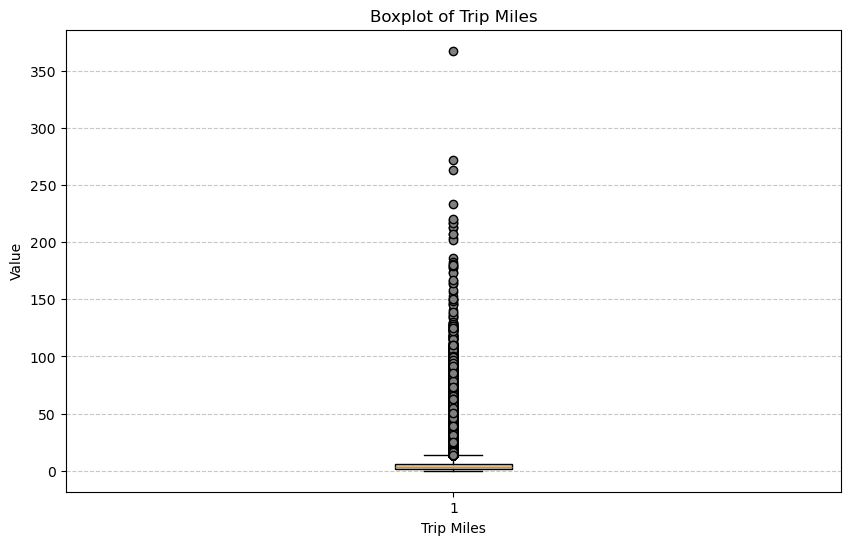

In [21]:
# Create a boxplot for trip_miles
plt.figure(figsize=(10, 6))

boxprops = dict(linestyle='-', linewidth=1, facecolor='lightblue')
medianprops = dict(linestyle='-', linewidth=1, color='red')
whiskerprops = dict(linestyle='--', linewidth=1, color='green')
capprops = dict(linestyle='-', linewidth=2, color='blue')
flierprops = dict(marker='o', markerfacecolor='grey', markersize=6, linestyle='none')

plt.boxplot(df_clean['trip_miles'], 
            boxprops=boxprops, 
            flierprops=flierprops,
            patch_artist=True)

# Add titles and labels
plt.title('Boxplot of Trip Miles')
plt.xlabel('Trip Miles')
plt.ylabel('Value')

# Adding grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [22]:
# Save the dataframe for trip_miles as CSV
trip_miles_df = df_clean[['trip_miles']]
trip_miles_df.to_csv('Plots/trip_miles_data.csv', index=False)

### Linear Regression model

In [23]:
df_clean.head()

,DOLocationID,PULocationID,trip_miles,trip_time,base_passenger_fare,congestion_surcharge,tips,driver_pay,month,day,hour,minute
0,145,223,3.83,1131,18.74,0.00,0.00,17.55,1,1,0,50
1,151,236,1.84,645,16.64,2.75,3.09,13.75,1,1,0,48
2,78,60,1.75,633,24.23,0.00,0.00,13.92,1,1,0,27
3,95,175,7.13,797,21.03,0.00,4.70,15.98,1,1,0,51
4,182,198,14.07,1848,55.87,0.00,6.98,38.79,1,1,0,28


In [24]:
# Reformat data of the independent variable X as a single-column array
X = df_clean["trip_miles"].values.reshape(-1, 1)

# Create an array for the dependent variable y
y = df_clean["base_passenger_fare"].values

In [25]:
from sklearn.model_selection import train_test_split

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [48]:
print(X_train.shape)

(1249399, 9)


In [26]:
# Create a model with scikit-learn
model_linear = LinearRegression()

# Fit the data into the model
model_linear.fit(X_train, y_train)

LinearRegression()

In [27]:
model_linear.score(X_test, y_test)

0.7669095311625672

In [28]:
# Make predictions using the X set
predicted_y_values = model_linear.predict(X)

In [29]:
# Create a copy of the original data
df_clean_predicted = df_clean.copy()

# Add a column with the predicted salary values
df_clean_predicted["base_passenger_fare_predict"] = predicted_y_values

# Display sample data
df_clean_predicted.head()

,DOLocationID,PULocationID,trip_miles,trip_time,base_passenger_fare,congestion_surcharge,tips,driver_pay,month,day,hour,minute,base_passenger_fare_predict
0,145,223,3.83,1131,18.74,0.00,0.00,17.55,1,1,0,50,21.277516
1,151,236,1.84,645,16.64,2.75,3.09,13.75,1,1,0,48,14.883689
2,78,60,1.75,633,24.23,0.00,0.00,13.92,1,1,0,27,14.594521
3,95,175,7.13,797,21.03,0.00,4.70,15.98,1,1,0,51,31.880343
4,182,198,14.07,1848,55.87,0.00,6.98,38.79,1,1,0,28,54.178411


In [30]:
# Compute metrics for the linear regression model: score, r2, mse, rmse, std
score = model_linear.score(X, y, sample_weight=None)
r2 = r2_score(y, predicted_y_values)
mse = mean_squared_error(y, predicted_y_values)
rmse = np.sqrt(mse)
std = np.std(y)
mae = mean_absolute_error(y, predicted_y_values)

# Print relevant metrics.
print(f"The score is {score}.")
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")
print(f"The mean absolute error is {mae}.")

The score is 0.7639358341835152.
The r2 is 0.7639358341835152.
The mean squared error is 113.45590449947669.
The root mean squared error is 10.651568170906888.
The standard deviation is 21.92292599488805.
The mean absolute error is 6.34154137296523.


### Incorporating latitude and longitude to dataframe

In [31]:
coordinates_df = pd.read_csv('Coordinates/taxi_zone_lookup_coordinates.csv')
coordinates_df.head()

,LocationID,Borough,Zone,service_zone,latitude,longitude
0,1,EWR,Newark Airport,EWR,40.69288,-74.185450
1,2,Queens,Jamaica Bay,Boro Zone,40.60570,-73.871300
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,40.86521,-73.843555
3,4,Manhattan,Alphabet City,Yellow Zone,40.72599,-73.980570
4,5,Staten Island,Arden Heights,Boro Zone,40.55640,-74.173500


In [32]:
# Set the index for the coordinates_df
coordinates_df.set_index('LocationID', inplace=True)

# Join on the DOLocationID
df_clean.set_index('DOLocationID', inplace=True)
df_merged_do = df_clean.join(coordinates_df, on='DOLocationID', rsuffix='_DO')

# Join on the PULocationID
df_merged_do.set_index('PULocationID', inplace=True)
df_merged_full = df_merged_do.join(coordinates_df, on='PULocationID', rsuffix='_PU')

# Reset indices if needed
df_merged_full.reset_index(inplace=True)

# Rename the columns for clarity
df_merged_full.rename(columns={
    'latitude': 'latitude_DO', 
    'longitude': 'longitude_DO', 
    'latitude_PU': 'latitude_PU', 
    'longitude_PU': 'longitude_PU'
}, inplace=True)

# Check the result
print(df_merged_full.head())


   PULocationID  trip_miles  trip_time  base_passenger_fare  \
0           223        3.83       1131                18.74   
1           236        1.84        645                16.64   
2            60        1.75        633                24.23   
3           175        7.13        797                21.03   
4           198       14.07       1848                55.87   

   congestion_surcharge  tips  driver_pay  month  day  hour  ...    Borough  \
0                  0.00  0.00       17.55      1    1     0  ...     Queens   
1                  2.75  3.09       13.75      1    1     0  ...  Manhattan   
2                  0.00  0.00       13.92      1    1     0  ...      Bronx   
3                  0.00  4.70       15.98      1    1     0  ...     Queens   
4                  0.00  6.98       38.79      1    1     0  ...      Bronx   

                             Zone service_zone latitude_DO  longitude_DO  \
0  Long Island City/Hunters Point    Boro Zone   40.741247    -73.9426

In [33]:
# Drop the non-beneficial columns
df_clean_coord = df_merged_full.drop(columns=['service_zone_PU', 'Borough_PU', 'Zone_PU','PULocationID'
                                             ])

In [34]:
# Haversine function - To obtain trip_miles_calculated based on latitude & longitude
def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 3956  # Radius of Earth in miles
    return c * r

# Apply the Haversine function to calculate trip miles
df_clean_coord['trip_miles_calculated'] = df_clean_coord.apply(lambda row: haversine(row['latitude_PU'], row['longitude_PU'], row['latitude_DO'], row['longitude_DO']), axis=1)

# Display the DataFrame with the new 'trip_miles' column
df_clean_coord.head()

,trip_miles,trip_time,base_passenger_fare,congestion_surcharge,tips,driver_pay,month,day,hour,minute,Borough,Zone,service_zone,latitude_DO,longitude_DO,latitude_PU,longitude_PU,trip_miles_calculated
0,3.83,1131,18.74,0.00,0.00,17.55,1,1,0,50,Queens,Long Island City/Hunters Point,Boro Zone,40.741247,-73.942628,40.77376,-73.90494,2.987404
1,1.84,645,16.64,2.75,3.09,13.75,1,1,0,48,Manhattan,Manhattan Valley,Yellow Zone,40.797045,-73.969725,40.76410,-73.95600,2.385194
2,1.75,633,24.23,0.00,0.00,13.92,1,1,0,27,Bronx,East Tremont,Boro Zone,40.845390,-73.891140,40.83359,-73.88837,0.827482
3,7.13,797,21.03,0.00,4.70,15.98,1,1,0,51,Queens,Forest Hills,Boro Zone,40.718100,-73.844800,40.74905,-73.75668,5.081536
4,14.07,1848,55.87,0.00,6.98,38.79,1,1,0,28,Bronx,Parkchester,Boro Zone,40.838300,-73.856600,40.70440,-73.90180,9.542481


In [35]:
# Calculate the correlation matrix
correlation_matrix = df_clean_coord[['base_passenger_fare', 'trip_miles', 'trip_miles_calculated']].corr()

# Display the correlation matrix
print(correlation_matrix)

                       base_passenger_fare  trip_miles  trip_miles_calculated
base_passenger_fare               1.000000    0.874035               0.099191
trip_miles                        0.874035    1.000000               0.160523
trip_miles_calculated             0.099191    0.160523               1.000000


#### The results indicate is better to use the trip_miles instead of the trip_miles_calculated since its correlation with the base_passenger fare is higher. This is expected since the Haversine function calculated the distance based on the straight distance, without considering streets/avenue, geometry of the city and any additional route the driver may need to take to arrive to the drop off location.

### Neural Network Model

#### Neural network NN features:
DOLocationID, PULocationID, trip_miles, trip_time, base_passenger_fare, driver_pay, month, day, hour, minute

In [38]:
# Drop the non-beneficial columns
df_clean = df.drop(columns=['hvfhs_license_num',
                            'request_datetime', 'tolls', 'bcf', 'sales_tax', 'airport_fee', 'congestion_surcharge',
                            'tips', 'PUBorough', 'PUZone', 'DOBorough', 'DOZone', 'Unnamed: 0', 'date'
                           ])
df_clean.shape

(1670353, 10)

In [39]:
df_clean.head()

,DOLocationID,PULocationID,trip_miles,trip_time,base_passenger_fare,driver_pay,month,day,hour,minute
0,145,223,3.83,1131,18.74,17.55,1,1,0,50
1,151,236,1.84,645,16.64,13.75,1,1,0,48
2,78,60,1.75,633,24.23,13.92,1,1,0,27
3,95,175,7.13,797,21.03,15.98,1,1,0,51
4,182,198,14.07,1848,55.87,38.79,1,1,0,28


In [40]:
# Import the dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf

In [41]:
# Remove base_passenger_fare target from data
y = df_clean.base_passenger_fare.values
X = df_clean.drop(columns="base_passenger_fare").values

# Convert y to a DataFrame to count occurrences. Remove classes with only 1 concurrence
y_df = pd.DataFrame(y, columns=["base_passenger_fare"])

# Count the occurrences of each class
class_counts = y_df['base_passenger_fare'].value_counts()

# Filter out the classes ocurring once
valid_classes = class_counts[class_counts > 1].index
y_filtered = y_df[y_df['base_passenger_fare'].isin(valid_classes)]
X_filtered = X[y_df['base_passenger_fare'].isin(valid_classes)]

# Convert to numpy arrays
y_filtered = y_filtered['base_passenger_fare'].values
X_filtered = X_filtered

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, random_state=42, stratify=y_filtered)

In [42]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [43]:
print(X_train_scaled.shape)

(1249399, 9)


In [45]:
print(X_test_scaled.shape)

(416467, 9)


In [46]:
# Define the deep learning model 
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=30, activation="relu", input_dim=X_train_scaled.shape[1]))
nn_model.add(tf.keras.layers.Dense(units=15, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=10, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=1))


# Compile the Sequential model together and customize metrics
#nn_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
nn_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_error"])

# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_mae = nn_model.evaluate(X_test_scaled, y_test, verbose=2)
#model_loss, model_mse = nn_model.evaluate(X_test_scaled, y_test, verbose=2)


print(f"Loss: {model_loss}, MAE: {model_mae}")
print(f"rmse: {model_loss**0.5}")

#print(f"Loss: {model_loss}, MSE: {model_mse}")
#print(f"rmse: {model_mse**0.5}")

Epoch 1/50
39044/39044 ━━━━━━━━━━━━━━━━━━━━ 38s 937us/step - loss: 67.1078 - mean_absolute_error: 4.6106
Epoch 2/50
39044/39044 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step - loss: 39.4824 - mean_absolute_error: 3.8418
Epoch 3/50
39044/39044 ━━━━━━━━━━━━━━━━━━━━ 57s 1ms/step - loss: 38.7839 - mean_absolute_error: 3.8044
Epoch 4/50
39044/39044 ━━━━━━━━━━━━━━━━━━━━ 35s 905us/step - loss: 37.9619 - mean_absolute_error: 3.7827
Epoch 5/50
39044/39044 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step - loss: 37.3654 - mean_absolute_error: 3.7202
Epoch 6/50
39044/39044 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step - loss: 36.6290 - mean_absolute_error: 3.6973
Epoch 7/50
39044/39044 ━━━━━━━━━━━━━━━━━━━━ 35s 882us/step - loss: 36.4367 - mean_absolute_error: 3.6789
Epoch 8/50
39044/39044 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step - loss: 36.2033 - mean_absolute_error: 3.6712
Epoch 9/50
39044/39044 ━━━━━━━━━━━━━━━━━━━━ 39s 994us/step - loss: 35.9571 - mean_absolute_error: 3.6602
Epoch 10/50
39044/39044 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - loss:

#### NN Model Results

The MAE of 3.53 dollars represents the average difference between the model's predictions and the actual fare amounts. On average, the model's predictions deviate from the true fare by about 3.53 dollars, which is fairly accurate given the typical fare range in between 10 to 60 dollars.

The RMSE of 5.65 dollars measures the standard deviation of the residuals (prediction errors). It indicates that the model's predictions are, on average, off by about 5.65 dollars.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


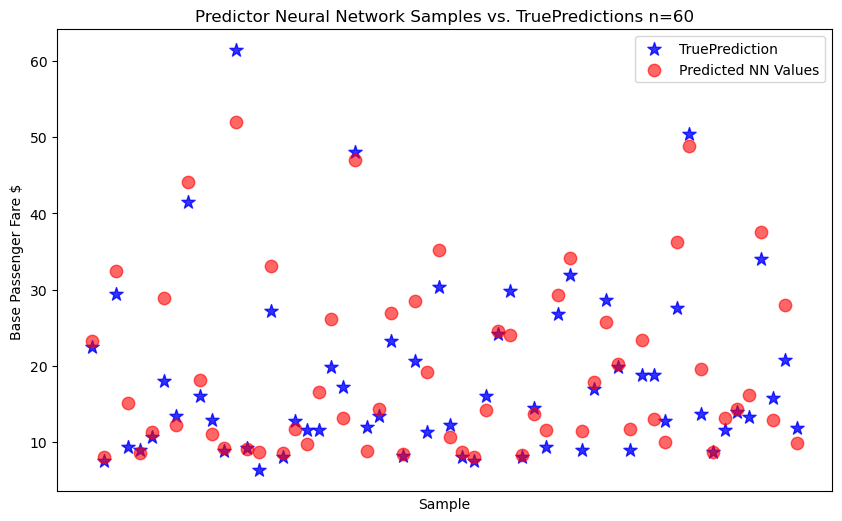

In [49]:
# Number of samples to plot
num_samples = 60

# Subset of the training data
indices = np.random.choice(X_train_scaled.shape[0], num_samples, replace=False)
X_train_subset = X_train_scaled[indices]
y_train_subset = y_train[indices]

# Predict the base_passenger_fare for these samples
y_train_pred = nn_model.predict(X_train_subset)

# Plot the training samples and their predictions
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(num_samples), y_train_subset, label='TruePrediction', color='blue', marker='*', alpha=0.8, s=100)
plt.scatter(np.arange(num_samples), y_train_pred, label='Predicted NN Values', color='red',  alpha=0.6,  s=80)
plt.xlabel('Sample')
plt.ylabel('Base Passenger Fare $')
plt.legend()
plt.title('Predictor Neural Network Samples vs. TruePredictions n=60')

plt.xticks([])

plt.show()



### -------------------------------------------------

#### Neural network NN20 features:

DOLocationID, PULocationID, trip_miles (Filtered by <=20 miles), trip_time, base_passenger_fare, driver_pay, month, day, hour, minute

In [50]:
# Filter the DataFrame to remove rows where trip_miles are greater than 20
df_clean20 = df_clean[df_clean['trip_miles'] <= 20]

In [51]:
df_clean20.head()

,DOLocationID,PULocationID,trip_miles,trip_time,base_passenger_fare,driver_pay,month,day,hour,minute
0,145,223,3.83,1131,18.74,17.55,1,1,0,50
1,151,236,1.84,645,16.64,13.75,1,1,0,48
2,78,60,1.75,633,24.23,13.92,1,1,0,27
3,95,175,7.13,797,21.03,15.98,1,1,0,51
4,182,198,14.07,1848,55.87,38.79,1,1,0,28


In [52]:
# Remove base_passenger_fare target from data
y = df_clean20.base_passenger_fare.values
X = df_clean20.drop(columns="base_passenger_fare").values

# Convert y to a DataFrame to count occurrences. This to remove filter the classes with only 1 concurrence
y_df = pd.DataFrame(y, columns=["base_passenger_fare"])

# Count the occurrences of each class
class_counts = y_df['base_passenger_fare'].value_counts()

# Filter out the classes ocurring once
valid_classes = class_counts[class_counts > 1].index
y_filtered = y_df[y_df['base_passenger_fare'].isin(valid_classes)]
X_filtered = X[y_df['base_passenger_fare'].isin(valid_classes)]

# Convert back to numpy arrays
y_filtered = y_filtered['base_passenger_fare'].values
X_filtered = X_filtered

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, random_state=42, stratify=y_filtered)

In [53]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [54]:
# Define the deep learning model 
nn_model20 = tf.keras.models.Sequential()
nn_model20.add(tf.keras.layers.Dense(units=30, activation="relu", input_dim=X_train_scaled.shape[1]))
nn_model20.add(tf.keras.layers.Dense(units=15, activation="relu"))
nn_model20.add(tf.keras.layers.Dense(units=10, activation="relu"))
nn_model20.add(tf.keras.layers.Dense(units=1))

# Compile the Sequential model together and customize metrics
#nn_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])
nn_model20.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_absolute_error"])

# Train the model
fit_model = nn_model20.fit(X_train_scaled, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_mae = nn_model20.evaluate(X_test_scaled, y_test, verbose=2)
#model_loss, model_mse = nn_model.evaluate(X_test_scaled, y_test, verbose=2)


print(f"Loss: {model_loss}, MAE: {model_mae}")
print(f"rmse: {model_loss**0.5}")

#print(f"Loss: {model_loss}, MSE: {model_mse}")
#print(f"rmse: {model_mse**0.5}")

Epoch 1/50
38097/38097 ━━━━━━━━━━━━━━━━━━━━ 34s 865us/step - loss: 49.2202 - mean_absolute_error: 4.2058
Epoch 2/50
38097/38097 ━━━━━━━━━━━━━━━━━━━━ 32s 851us/step - loss: 31.9290 - mean_absolute_error: 3.5938
Epoch 3/50
38097/38097 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step - loss: 31.5953 - mean_absolute_error: 3.5604
Epoch 4/50
38097/38097 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - loss: 30.9323 - mean_absolute_error: 3.5161
Epoch 5/50
38097/38097 ━━━━━━━━━━━━━━━━━━━━ 33s 858us/step - loss: 30.5003 - mean_absolute_error: 3.5000
Epoch 6/50
38097/38097 ━━━━━━━━━━━━━━━━━━━━ 32s 848us/step - loss: 30.0873 - mean_absolute_error: 3.4732
Epoch 7/50
38097/38097 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step - loss: 29.8552 - mean_absolute_error: 3.4576
Epoch 8/50
38097/38097 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step - loss: 29.5953 - mean_absolute_error: 3.4325
Epoch 9/50
38097/38097 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - loss: 29.0802 - mean_absolute_error: 3.4155
Epoch 10/50
38097/38097 ━━━━━━━━━━━━━━━━━━━━ 38s 996us/step - los

#### NN20 Model Results

The NN20 model is more accurate than the NN model, by lower loss, MAE, and RMSE values. This means that the NN20 model provides predictions that are closer to the true values of the base passenger fare.

The smaller difference in MAE and RMSE between the models indicates that NN20 has less variance in its errors and fewer extreme errors compared to NN model.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


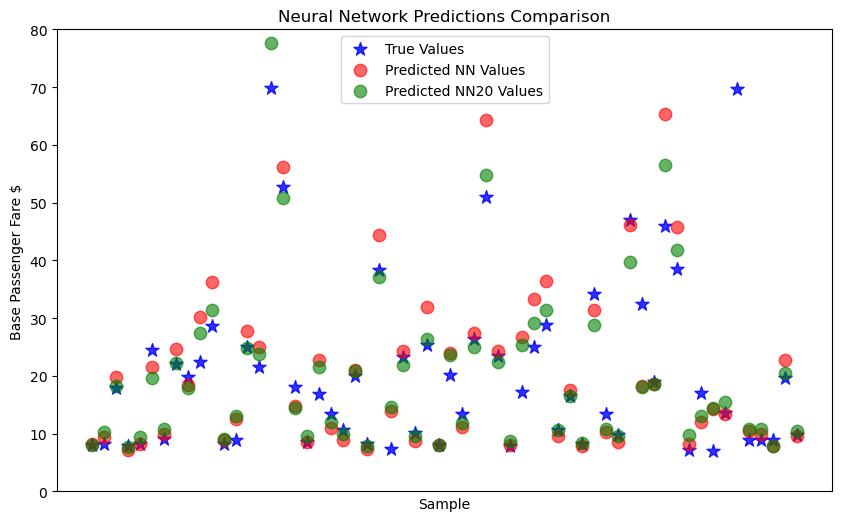

In [57]:
# Number of samples to plot
num_samples = 60

# Get a subset of the training data
indices = np.random.choice(X_train_scaled.shape[0], num_samples, replace=False)
X_train_subset = X_train_scaled[indices]
y_train_subset = y_train[indices]

# Predict the base_passenger_fare for these samples using both models
y_train_pred_nn = nn_model.predict(X_train_subset)
y_train_pred_nn20 = nn_model20.predict(X_train_subset)

# Plot the training samples and their predictions from both models
plt.figure(figsize=(10, 6))

# Plot true values
plt.scatter(np.arange(num_samples), y_train_subset, label='True Values', color='blue', marker='*', alpha=0.8, s=100)

# Plot predictions from nn_model
plt.scatter(np.arange(num_samples), y_train_pred_nn, label='Predicted NN Values', color='red', alpha=0.6, s=80)

# Plot predictions from nn_model20
plt.scatter(np.arange(num_samples), y_train_pred_nn20, label='Predicted NN20 Values', color='green', alpha=0.6, s=80)

plt.xlabel('Sample')
plt.ylabel('Base Passenger Fare $')
plt.legend()
plt.title('Neural Network Predictions Comparison')

# Set y-axis limit to $80
plt.ylim(0, 80)

plt.xticks([])

plt.show()


In [58]:
# Save the DataFrame to a CSV file
df_plot_data = pd.DataFrame({
    "True Values": y_train_subset.flatten(),
    "Predicted NN Values": y_train_pred_nn.flatten(),
    "Predicted NN20 Values": y_train_pred_nn20.flatten()
})
8

df_plot_data.to_csv('Plots/nn_predictions.csv', index=False)

12699/12699 ━━━━━━━━━━━━━━━━━━━━ 9s 734us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 10s 766us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 9s 717us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 9s 674us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 8s 623us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 8s 612us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 8s 656us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 12s 907us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 10s 798us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 9s 695us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 9s 728us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 8s 611us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 9s 677us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 8s 630us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 12s 946us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 13s 988us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 12s 940us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 10s 760us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 9s 681us/step
12699/12699 ━━━━━━━━━━━━━━━━━━━━ 8s 600us/step
12699/1

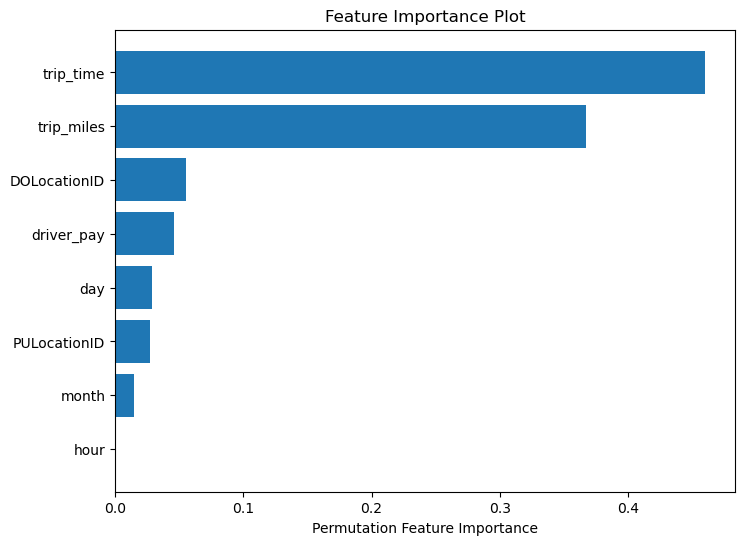

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Define a custom scoring function
def custom_scorer(model, X, y):
    y_pred = model.predict(X)
    return -mean_squared_error(y, y_pred)

# Apply permutation importance
result = permutation_importance(
    estimator=nn_model20,
    X=X_test_scaled,
    y=y_test,
    scoring=custom_scorer,  # Using the custom scorer
    n_repeats=10,
    random_state=42
)

# Features to exclude
excluded_features = ['base_passenger_fare']

# Filter the features based on the excluded list
sorted_idx = np.argsort(result.importances_mean)
filtered_features = [feature for feature in df_clean.columns[sorted_idx] if feature not in excluded_features]
filtered_importances = [result.importances_mean[i] for i in sorted_idx if df_clean.columns[i] not in excluded_features]

# Normalize the importances to sum to 1
total_importance = sum(filtered_importances)
normalized_importances = [importance / total_importance for importance in filtered_importances]

# Filter indices as well
filtered_sorted_idx = np.argsort(normalized_importances)

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(range(len(filtered_sorted_idx)), np.array(normalized_importances)[filtered_sorted_idx])
plt.yticks(range(len(filtered_sorted_idx)), np.array(filtered_features)[filtered_sorted_idx])
plt.xlabel("Permutation Feature Importance")
plt.title("Feature Importance Plot")

# Save the current plot to a variable
plt_features20 = plt.gcf()

# Display the plot
plt.show()


In [60]:
# Save to CSV file
NN_feature_importance_df = pd.DataFrame({
    'Feature': np.array(filtered_features)[filtered_sorted_idx],
    'Importance': np.array(normalized_importances)[filtered_sorted_idx]
})

NN_feature_importance_df.to_csv('Plots/nn_features.csv', index=False)